In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import utils as ut
import sys
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

system_name = 'ant_cons'
run_name = '2p_gamma_pcons_rand_b'
data_dir = 'data/' + system_name + '_multi/' + run_name + '/'
plot_dir = 'plots/' + system_name + '_multi/' + run_name + '/'

### Importing the paramters

In [3]:
par_info = ut.read_params(data_dir+'info.txt')
par_env0 = ut.read_params(data_dir+'0_param_env.txt')
#print(par_info)

### Importing the data

In [4]:
def import_policies(data_dir):
    forager_p = np.zeros((int(par_info['counts']), int(par_env0['max_k'])))
    recipient_p = np.zeros((int(par_info['counts']), int(par_env0['max_k'])-1))
    gammas, pcons = [], []
    for i in range(int(par_info['counts'])):
        l_forag = np.array(ut.read_traj(data_dir+str(i)+'_best_policy_0.txt', False)[1:int(par_env0['max_k'])+1])
        l_rec = np.array(ut.read_traj(data_dir+str(i)+'_best_policy_1.txt', False)[1:int(par_env0['max_k'])+1])
        penv = ut.read_params(data_dir+str(i)+'_param_env.txt')
        palg = ut.read_params(data_dir+str(i)+'_param_alg.txt')
        gammas.append(palg['gamma'])
        pcons.append(penv['p_consume'])
        forager_p[i] = np.array(l_forag)[:,0]
        recipient_p[i] = np.array(l_rec)[:-1,0]
        sys.stdout.write("\rImported files: {}/{}".format(i+1, int(par_info['counts'])))
        sys.stdout.flush()
    return forager_p, recipient_p, gammas, pcons

def import_info(data_dir):
    return_p = np.zeros(int(par_info['counts']))
    gamma_stop, for_stop, colony_stop = np.zeros(int(par_info['counts'])), np.zeros(int(par_info['counts'])), np.zeros(int(par_info['counts']))
    for i in range(int(par_info['counts'])):
        ret_traj, h = ut.read_traj(data_dir+str(i)+'_env_info_traj.txt')
        return_p[i] = ret_traj[-1][3]
        for_stop[i] = ret_traj[-1][0]
        colony_stop[i] = ret_traj[-1][1]
        gamma_stop[i] = ret_traj[-1][2]
        sys.stdout.write("\rImported files: {}/{}".format(i+1, int(par_info['counts'])))
        sys.stdout.flush()
    return return_p, gamma_stop, for_stop, colony_stop

In [4]:
forager_p, recipient_p, gammas, pcons = import_policies(data_dir)
return_p, gamma_stop, for_stop, colony_stop = import_info(data_dir)

Imported files: 100/100

In [5]:
print(gammas[29], pcons[29])
print(return_p[29], [np.sum(p>0.5) for p in forager_p][29])

0.683772233983162 0.2222222222222222
0.76774 1


In [6]:
print(gammas[29], pcons[29])
print(return_p[29], [np.sum(p>0.5) for p in forager_p][29])

0.683772233983162 0.2222222222222222
0.76774 1


### How many policy are deterministic?
Just a visual representation

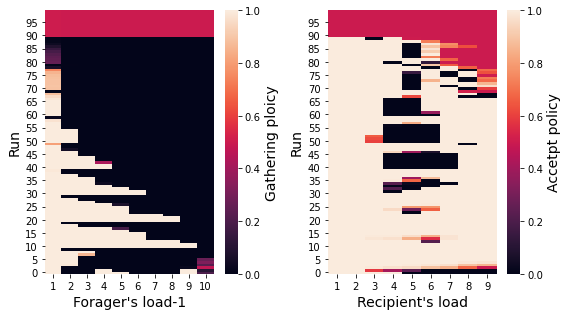

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4.5))
      
sns.heatmap(forager_p, ax=ax1, vmin=0, vmax=1., xticklabels=np.arange(1,par_env0['max_k']+1,dtype=int))
ax1.invert_yaxis()
ax1.set_ylabel('Run', fontsize=14)
ax1.set_xlabel('Forager\'s load-1', fontsize=14)
colorbar = ax1.collections[0].colorbar
colorbar.set_label('Gathering ploicy', fontsize=14)

sns.heatmap(recipient_p, ax=ax2, vmin=0, vmax=1., xticklabels=np.arange(1,par_env0['max_k'],dtype=int))
ax2.invert_yaxis()
ax2.set_ylabel('Run', fontsize=14)
ax2.set_xlabel('Recipient\'s load', fontsize=14)
colorbar = ax2.collections[0].colorbar
colorbar.set_label('Accetpt policy', fontsize=14)

plt.tight_layout()
plt.savefig(plot_dir + 'policies.png', dpi=200)

## Parameter space

In [5]:
def build_matrices(forager_p, recipient_p, gammas, pcons, return_p, gamma_stop, for_stop, colony_stop):
    n_gath_flat = [np.sum(p>0.5) for p in forager_p]
    n_acc_flat = [np.sum(p>0.5) for p in recipient_p]
    gamma_set = np.sort(list(set(gammas)))
    pcons_set = np.sort(list(set(pcons)))
    n_gath_mat = np.zeros((len(pcons_set),len(gamma_set)))
    n_acc_mat = np.zeros((len(pcons_set),len(gamma_set)))
    ret_for_mat = np.zeros((len(pcons_set), len(gamma_set)))
    gamma_stop_mat = np.zeros((len(pcons_set), len(gamma_set)))
    colony_stop_mat = np.zeros((len(pcons_set), len(gamma_set)))
    ep_time_mat = np.zeros((len(pcons_set), len(gamma_set)))
    #ep_len_mat = np.zeros((len(gamma_set), len(pcons_set)))

    for k in range(len(n_gath_flat)):
        g, pc = gammas[k], pcons[k]
        j = np.where(gamma_set == gammas[k])[0][0]
        i = np.where(pcons_set == pcons[k])[0][0]
        n_gath_mat[i,j] = n_gath_flat[k]
        n_acc_mat[i,j] = n_acc_flat[k]
        ret_for_mat[i,j] = return_p[k]
        ep_time_mat[i,j] = 1/(gamma_stop[k] + for_stop[k] + colony_stop[k])
        gamma_stop_mat[i,j] = gamma_stop[k] * ep_time_mat[i,j]
        colony_stop_mat[i,j] = colony_stop[k] * ep_time_mat[i,j]
    
    return n_gath_mat, n_acc_mat, ret_for_mat, ep_time_mat, gamma_stop_mat, colony_stop_mat

In [9]:
gamma_set = np.sort(list(set(gammas)))
pcons_set = np.sort(list(set(pcons)))
n_gath_mat, n_acc_mat, ret_for_mat, ep_time_mat, gamma_stop_mat, colony_stop = \
    build_matrices(forager_p, recipient_p, gammas, pcons, return_p, gamma_stop, for_stop, colony_stop)

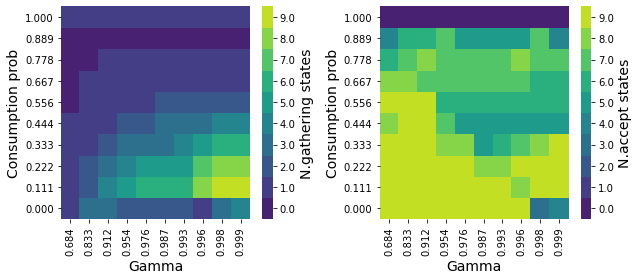

In [10]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,4))
cmap = sns.color_palette("viridis", int(np.max(n_gath_mat))+1)

sns.heatmap(n_gath_mat, cmap=cmap,
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax1)
ax1.set_ylabel('Consumption prob', fontsize=14)
ax1.set_xlabel('Gamma', fontsize=14)
ax1.invert_yaxis()
colorbar = ax1.collections[0].colorbar
delta = np.max(n_gath_mat)/(np.max(n_gath_mat)+1)
tics = [delta*i+ delta/2 for i in range(int(np.max(n_gath_mat))+1)]
colorbar.set_ticks(tics)
colorbar.set_ticklabels(np.arange(np.max(n_gath_mat)+1))
colorbar.set_label('N.gathering states', fontsize=14)

sns.heatmap(n_acc_mat, cmap=cmap,
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax2)
ax2.set_ylabel('Consumption prob', fontsize=14)
ax2.set_xlabel('Gamma', fontsize=14)
ax2.invert_yaxis()
colorbar = ax2.collections[0].colorbar
delta = np.max(n_acc_mat)/(np.max(n_acc_mat)+1)
tics = [delta*i+ delta/2 for i in range(int(np.max(n_acc_mat))+1)]
colorbar.set_ticks(tics)
colorbar.set_ticklabels(np.arange(np.max(n_acc_mat)+1))
colorbar.set_label('N.accept states', fontsize=14)

plt.tight_layout()
plt.savefig(plot_dir + 'param_space.png', dpi=200)

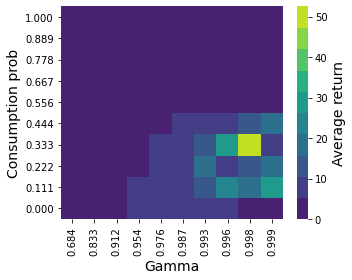

In [11]:
fig, ax1 = plt.subplots(1,figsize=(5,4))
cmap = sns.color_palette("viridis", int(np.max(n_gath_mat))+1)

sns.heatmap(ret_for_mat, cmap=cmap,
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax1)
ax1.set_ylabel('Consumption prob', fontsize=14)
ax1.set_xlabel('Gamma', fontsize=14)
ax1.invert_yaxis()
colorbar = ax1.collections[0].colorbar
colorbar.set_label('Average return', fontsize=14)


plt.tight_layout()
plt.savefig(plot_dir + 'param_space_return.png', dpi=200)

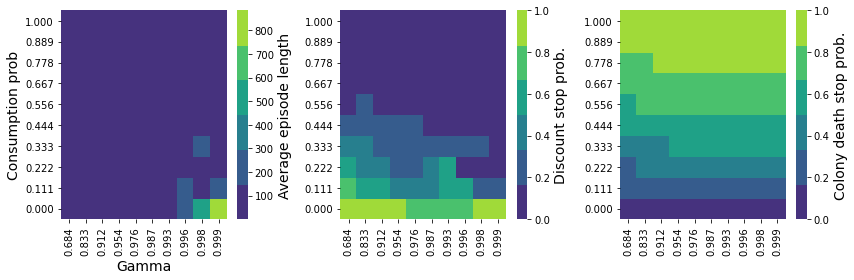

In [12]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,4))
cmap = sns.color_palette("viridis")

sns.heatmap(ep_time_mat, cmap=cmap,
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax1)
ax1.set_ylabel('Consumption prob', fontsize=14)
ax1.set_xlabel('Gamma', fontsize=14)
ax1.invert_yaxis()
colorbar = ax1.collections[0].colorbar
colorbar.set_label('Average episode length', fontsize=14)

sns.heatmap(gamma_stop_mat, cmap=cmap, vmin=0, vmax=1,
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax2)
#ax2.set_ylabel('Consumption prob', fontsize=14)
#ax2.set_xlabel('Gamma', fontsize=14)
ax2.invert_yaxis()
colorbar = ax2.collections[0].colorbar
colorbar.set_label('Discount stop prob.', fontsize=14)

sns.heatmap(colony_stop, cmap=cmap, vmin=0, vmax=1,
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax3)
#ax3.set_ylabel('Consumption prob', fontsize=14)
#ax3.set_xlabel('Gamma', fontsize=14)
ax3.invert_yaxis()
colorbar = ax3.collections[0].colorbar
colorbar.set_label('Colony death stop prob.', fontsize=14)

plt.tight_layout()
plt.savefig(plot_dir + 'param_space_times.png', dpi=200)

## Comparing 

In [6]:
def second_best_arg(vals):
    vals = np.array(vals)
    amax = np.argmax(vals)
    vals[amax] = min(vals)
    return np.argmax(vals)
    

def rel_error(vals):
    #print(vals)
    vals = np.array(vals)
    best = max(vals)
    second_best = vals[second_best_arg(vals)]
    if best != 0:
        return abs(best-second_best)/best
    else:
        return 0.0
    
def policy_dist(p1, p2):
    diff = np.array(p1)-np.array(p2)
    abs_diff = np.abs(diff)
    return abs_diff.sum()

In [27]:
run_base_name = '2p_gamma_pcons_low'
run_to_compare = [run_base_name+'_a', run_base_name+'_b']
#run_to_compare = [run_base_name+'_a', run_base_name+'_b', run_base_name+'_c']
plot_dir_comp = 'plots/' + system_name + '_multi/'+run_base_name+'/'

In [28]:
forager_ps, recipient_ps = [], []
forager_mats, recipient_mats, return_mats, ep_time_mats, gamma_stop_mats, colony_stop_mats = [], [], [], [], [], []
data_dir = 'data/' + system_name + '_multi/'
init_vals = []

for run in run_to_compare:
    forager_p, recipient_p, gammas, pcons = import_policies(data_dir + run + '/')
    forager_ps.append(forager_p)
    recipient_ps.append(recipient_p)
    par_alg0 = ut.read_params(data_dir + run + '/0_param_alg.txt')
    init_vals.append(par_alg0['init_values'])
    #print(set(gammas), set(pcons))
    return_p, gamma_stop, for_stop, colony_stop = import_info(data_dir + run + '/')
    forager_mat, recipient_mat, return_mat, ep_time_mat, gamma_stop_mat, colony_stop_mat = build_matrices(forager_p, recipient_p, gammas, pcons, return_p, gamma_stop, for_stop, colony_stop)
    forager_mats.append(forager_mat)
    recipient_mats.append(recipient_mat)
    return_mats.append(return_mat)
    ep_time_mats.append(ep_time_mat)
    gamma_stop_mats.append(gamma_stop_mat)
    colony_stop_mats.append(colony_stop_mat)
    
gamma_set = np.sort(list(set(gammas)))
pcons_set = np.sort(list(set(pcons)))
print(init_vals)

Imported files: 100/100[2.0, 20.0]


In [29]:
rel_error_mat = np.apply_along_axis(rel_error, 0, return_mats)
max_ret_mat = np.argmax(return_mats, axis=0)
sec_max_ret_mat = np.apply_along_axis(second_best_arg, 0, return_mats)

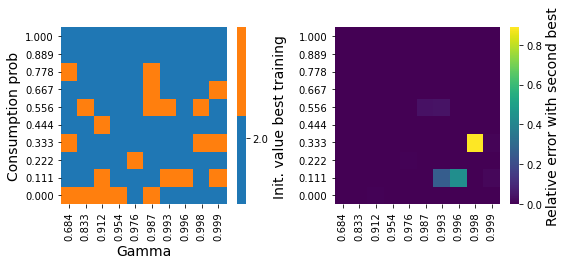

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3.5))
myColors = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(run_to_compare)]
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

sns.heatmap(max_ret_mat, cmap=cmap,
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax1)
ax1.set_ylabel('Consumption prob', fontsize=14)
ax1.set_xlabel('Gamma', fontsize=14)
ax1.invert_yaxis()
delta = (1+len(myColors))/len(myColors)
colorbar = ax1.collections[0].colorbar
colorbar.set_ticks([delta/2*(i+0.5) for i in range(len(myColors))])
colorbar.set_ticklabels([init_vals[i] for i in range(len(myColors))])
colorbar.set_label('Init. value best training', fontsize=14)

sns.heatmap(rel_error_mat, cmap='viridis',
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax2)
ax2.invert_yaxis()
colorbar = ax2.collections[0].colorbar
colorbar.set_label('Relative error with second best', fontsize=14)

plt.tight_layout()
plt.savefig(plot_dir_comp+'best_training.png', dpi=200)

In [31]:
forager_best, recipient_best, return_best, ep_time_best, gamma_stop_best, colony_stop_best = \
np.zeros((len(pcons_set),len(gamma_set))), np.zeros((len(pcons_set),len(gamma_set))), np.zeros((len(pcons_set),len(gamma_set))), \
np.zeros((len(pcons_set),len(gamma_set))), np.zeros((len(pcons_set),len(gamma_set))), np.zeros((len(pcons_set),len(gamma_set)))
forager_dist, recipient_dist = np.zeros((len(pcons_set),len(gamma_set))), np.zeros((len(pcons_set),len(gamma_set)))
forager_p_best, recipient_p_best = [], []

for k in range(len(pcons_set)*len(gamma_set)):
    j = np.where(gamma_set == gammas[k])[0][0]
    i = np.where(pcons_set == pcons[k])[0][0]
    forager_p_best.append(forager_ps[max_ret_mat[i,j]][k])
    forager_dist[i,j] = policy_dist(forager_ps[max_ret_mat[i,j]][k], forager_ps[sec_max_ret_mat[i,j]][k])
    recipient_p_best.append(recipient_ps[max_ret_mat[i,j]][k])
    recipient_dist[i,j] = policy_dist(recipient_ps[max_ret_mat[i,j]][k], recipient_ps[sec_max_ret_mat[i,j]][k])
    forager_best[i,j] = forager_mats[max_ret_mat[i,j]][i,j]
    recipient_best[i,j] = recipient_mats[max_ret_mat[i,j]][i,j]
    return_best[i,j] = return_mats[max_ret_mat[i,j]][i,j]
    ep_time_best[i,j] = ep_time_mats[max_ret_mat[i,j]][i,j]
    gamma_stop_best[i,j] = gamma_stop_mats[max_ret_mat[i,j]][i,j]
    colony_stop_best[i,j] = colony_stop_mats[max_ret_mat[i,j]][i,j]

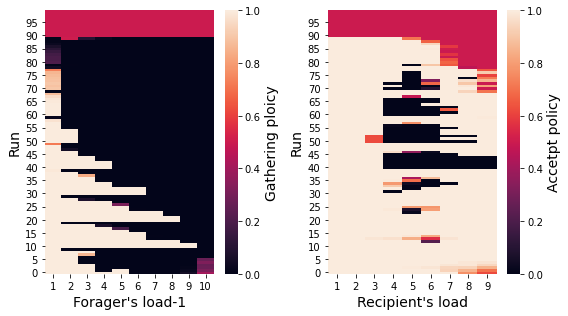

In [32]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(8,4.5))
      
sns.heatmap(forager_p_best, ax=ax1, vmin=0, vmax=1., xticklabels=np.arange(1,par_env0['max_k']+1,dtype=int))
ax1.invert_yaxis()
ax1.set_ylabel('Run', fontsize=14)
ax1.set_xlabel('Forager\'s load-1', fontsize=14)
colorbar = ax1.collections[0].colorbar
colorbar.set_label('Gathering ploicy', fontsize=14)

sns.heatmap(recipient_p_best, ax=ax2, vmin=0, vmax=1., xticklabels=np.arange(1,par_env0['max_k'],dtype=int))
ax2.invert_yaxis()
ax2.set_ylabel('Run', fontsize=14)
ax2.set_xlabel('Recipient\'s load', fontsize=14)
colorbar = ax2.collections[0].colorbar
colorbar.set_label('Accetpt policy', fontsize=14)

plt.tight_layout()
plt.savefig(plot_dir_comp + 'policies.png', dpi=200)

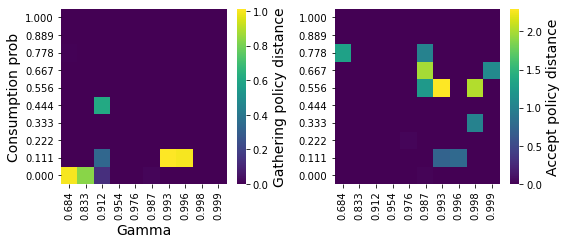

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(8,3.5))

sns.heatmap(forager_dist, cmap='viridis',
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax1)
ax1.set_ylabel('Consumption prob', fontsize=14)
ax1.set_xlabel('Gamma', fontsize=14)
ax1.invert_yaxis()
colorbar = ax1.collections[0].colorbar
colorbar.set_label('Gathering policy distance', fontsize=14)

sns.heatmap(recipient_dist, cmap='viridis',
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax2)
ax2.invert_yaxis()
colorbar = ax2.collections[0].colorbar
colorbar.set_label('Accept policy distance', fontsize=14)

plt.tight_layout()
plt.savefig(plot_dir_comp+'policy_distance.png', dpi=200)

1
[0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]


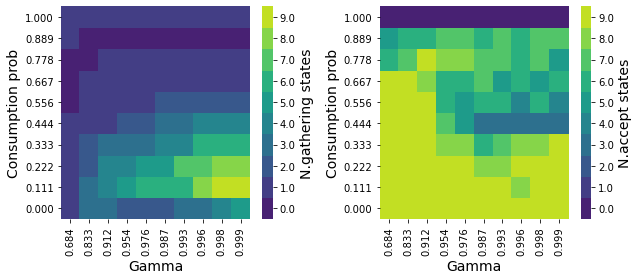

In [34]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(9,4))
cmap = sns.color_palette("viridis", int(np.max(forager_best))+1)

sns.heatmap(forager_best, cmap=cmap, vmin=0, vmax=int(np.max(forager_best))+1,
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax1)
ax1.set_ylabel('Consumption prob', fontsize=14)
ax1.set_xlabel('Gamma', fontsize=14)
ax1.invert_yaxis()
colorbar = ax1.collections[0].colorbar
delta = 1
print (delta)
tics = [delta*i+ delta/2 for i in range(int(np.max(forager_best))+1)]
print (tics)
colorbar.set_ticks(tics)
colorbar.set_ticklabels(np.arange(np.max(forager_best)+1))
colorbar.set_label('N.gathering states', fontsize=14)

sns.heatmap(recipient_best, cmap=cmap, vmin=0, vmax=int(np.max(recipient_best))+1,
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax2)
ax2.set_ylabel('Consumption prob', fontsize=14)
ax2.set_xlabel('Gamma', fontsize=14)
ax2.invert_yaxis()
colorbar = ax2.collections[0].colorbar
delta = 1
tics = [delta*i+ delta/2 for i in range(int(np.max(recipient_best))+1)]
colorbar.set_ticks(tics)
colorbar.set_ticklabels(np.arange(np.max(recipient_best)+1))
colorbar.set_label('N.accept states', fontsize=14)

plt.tight_layout()
plt.savefig(plot_dir_comp + 'param_space.png', dpi=200)

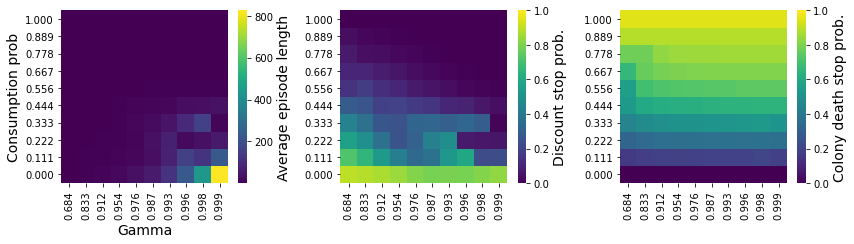

In [35]:
fig, (ax1, ax2, ax3) = plt.subplots(1,3,figsize=(12,3.5))
cmap = "viridis"

sns.heatmap(ep_time_best, cmap=cmap,
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax1)
ax1.set_ylabel('Consumption prob', fontsize=14)
ax1.set_xlabel('Gamma', fontsize=14)
ax1.invert_yaxis()
colorbar = ax1.collections[0].colorbar
colorbar.set_label('Average episode length', fontsize=14)

sns.heatmap(gamma_stop_best, cmap=cmap, vmin=0, vmax=1,
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax2)
#ax2.set_ylabel('Consumption prob', fontsize=14)
#ax2.set_xlabel('Gamma', fontsize=14)
ax2.invert_yaxis()
colorbar = ax2.collections[0].colorbar
colorbar.set_label('Discount stop prob.', fontsize=14)

sns.heatmap(colony_stop_best, cmap=cmap, vmin=0, vmax=1,
            xticklabels=["%4.3f" %g for g in gamma_set],
            yticklabels=["%4.3f" %p for p in pcons_set], ax=ax3)
#ax3.set_ylabel('Consumption prob', fontsize=14)
#ax3.set_xlabel('Gamma', fontsize=14)
ax3.invert_yaxis()
colorbar = ax3.collections[0].colorbar
colorbar.set_label('Colony death stop prob.', fontsize=14)

plt.tight_layout()
plt.savefig(plot_dir_comp + 'param_space_times.png', dpi=200)